# MBTA Vehicle Updates
I've been archiving the output of the MBTA's realtime vehicle updates API and making it available for download from http://mbta-history.apptic.xyz. This notebook illustrates how to retrieve and use the data programmatically with Python 3 and Pandas.

Ultimately, we'll create a visualization of actual arrival time vs. scheduled arrival time that looks something like this:

![Red Line delays](https://www.dropbox.com/s/px7u6oriz7dqv1j/Unknown.png?dl=1)

In [1]:
from datetime import datetime, timedelta
from io import BytesIO, TextIOWrapper
import os
import tarfile
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve

import numpy as np
import pandas as pd
import pytz

In [119]:
try:
  from ipywidgets import IntProgress, HBox, HTML
  from IPython.display import display

  def retrieve(*args, reporthook=None, **kwargs):
      "Wrapper around urlretrieve that displays a progress bar."
      bar = IntProgress(min=0, max=1, value=0)
      display(bar)
      def do_report(block, read, total):
          if total > bar.min:
              bar.max = total
              bar.value = (block+1)*read
          if reporthook:
              reporthook(block, read, total)

      return urlretrieve(*args, reporthook=do_report, **kwargs)
except ImportError:
  retrieve = urlretrieve

We'll define a function `get_updates` that takes a `datetime` argument and returns a pandas DataFrame containing all reported vehicle updates for that day (assuming they're available). You can also visit http://mbta-history.apptic.xyz directly, download the data for a particular day, then use `pandas.read_csv(path_to_csv_file)` to construct a dataframe.

In [9]:
def archive_url(dt):
    csv_filename = dt.strftime("%Y-%m-%d")
    return dt.strftime(f"http://mbta-history.apptic.xyz/%Y/%m/{csv_filename}.csv.gz")

def get_updates(dt):
    """Retrieves the vehicle updates for the given date from
    the archive site and read them into a pandas DataFrame.
    
    :param dt: a date-like object
    """
    # This reads the gzipped tarfile into memory, extracts the file,
    # and reads it directly into a dataframe.
    
    # Pandas can also read directly from URLs and file paths
    return pd.read_csv(archive_url(dt), dtype="unicode")

def download_updates(dt, verbose=True):
    """A convenience function that downloads and creates a DataFrame
    for data from the given datetime `dt`, with visual feedback for
    download progress and local caching.
    
    Creates a local directory called 'data' for storing downloaded data
    files. Checks there first for data before attempting to download.
    
    """
    os.makedirs("data", exist_ok=True)
    url = archive_url(dt)
    basename = os.path.basename(url)
    outfile = os.path.join("data", basename)
    log = lambda *m: verbose and print(*m)
    if not os.path.exists(outfile):
        log(f"Downloading {basename}...")
        retrieve(url, outfile)
        log("Download complete")
    else:
        log(f"{basename} exists")
    log("Reading file...")
        
    return pd.read_csv(outfile, dtype="unicode")

And let's retrieve the updates for February 9th:

In [8]:
# now_utc = pytz.utc.localize(datetime.utcnow())
# yesterday = now_utc.astimezone(pytz.timezone("US/Eastern")) - timedelta(days=3)

day = pytz.utc.localize(datetime(2018, 2, 9))

df = download_updates(day)
df.drop_duplicates(inplace=True)
df.head()

2018-02-09.csv.gz exists
Reading file...


,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon
0,983FD4A9,2018-02-09,70087,140,54539A74,IN_TRANSIT_TO,2018-02-09 07:02:03,42.31827163696289,-71.05227661132812
1,983FD4A9,2018-02-09,70087,140,54539A74,IN_TRANSIT_TO,2018-02-09 07:02:32,42.31679916381836,-71.05238342285156
2,983FD4A9,2018-02-09,70087,140,54539A74,INCOMING_AT,2018-02-09 07:02:56,42.31446075439453,-71.05227661132812
3,983FD4A9,2018-02-09,70087,140,54539A74,STOPPED_AT,2018-02-09 07:03:45,42.3105583190918,-71.05372619628906
4,983FD4A9,2018-02-09,70089,150,54539A74,IN_TRANSIT_TO,2018-02-09 07:04:11,42.308780670166016,-71.05441284179688


We can use the `DataFrame`'s `describe()` method to show summary statistics for each column.

In [10]:
desc = df.describe()
desc

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon
count,748507,748507,735753,748507,748507,748507,748507,748507,748507
unique,16938,1,7940,153,1229,3,75080,80936,49705
top,1,2018-02-09,64000,1,3003,STOPPED_AT,2018-02-09 22:44:20,42.349971771240234,-71.06482696533203
freq,1619,748507,4473,100031,1948,309929,43,755,766


Note that pandas is treating all the columns as categorical columns. Instead of getting the median, mean, max (&c) that we might expect, we see the count of non-empty values (`count`); the number of unique values in each column; the most frequent value for each column (`top`); and the number of times the top column occurs (`freq`).

The reason is that when we imported the CVS file, we specified a dtype of `"unicode"`, which prevents pandas from inferring the type of every column. On this dataset, certain columns can look numeric (`vehicle_id`, `stop_id`) when they ought—according to the GTFS spec—to be treated as strings. 

(Note: if we knew the column types in advance, we could save a lot of memory by providing converters or types at import time. I prefer `"unicode"` for exploration, since it behaves predictably)

## DataFrame

Briefly, a `DataFrame` consists of a number of `Series` with a shared index. You can think of a `Series` as a column of data with some extra metadata attached--a name and an index, for example--and lots of helper methods.

In our data, the `stop_sequence` column is an example of a `Series`.

We can pick out a single `Series` by name:

In [11]:
df["stop_sequence"].head()

0    140
1    140
2    140
3    140
4    150
Name: stop_sequence, dtype: object

And we can summarize it, if we'd like:

In [13]:
df["stop_sequence"].describe()

count     748507
unique       153
top            1
freq      100031
Name: stop_sequence, dtype: object

Note that when we run `describe()` on a `Series`, we get another `Series` back, with an index that should look familiar. Indexes can take many forms; among other things, they can be numeric, categorical, or hierarchical. In the case of the summary `Series`, it's a named index containing "count", "unique", "top", and "freq". 

So when we ran `describe()` on the DataFrame earlier and got another `DataFrame` back, pandas effectively ran `describe()` on each column (that is, each `Series`), then bundled all the summary `Series` together, using their shared index for the row names in the summary `DataFrame` we got back.

# Interlude: Vectorization
Operations on core pandas data structures like `DataFrame` and `Series` are **vectorized**. That means, in general, that when you perform an operation on a structure, it is applied across that structure's elements. What that looks like concretely depends on the operator (or method) and the operands.

Let's see a few quick examples using randomly generated dummy data:

In [28]:
# 5 x 5 DataFrame of pseudorandom integers between 1-99
from ipywidgets import HTML
n_df = pd.DataFrame(np.random.randint(1, 100, size=(5, 5)), columns=list("abcde"))
n_df2 = pd.DataFrame(np.random.randint(1, 100, size=(5, 5)), columns=list("abcde"))
display(n_df, n_df2)

,a,b,c,d,e
0,25,54,25,21,45
1,18,59,56,81,95
2,98,11,14,31,46
3,76,62,67,24,34
4,85,24,89,59,63


,a,b,c,d,e
0,79,72,58,67,59
1,82,14,98,27,17
2,72,8,49,89,90
3,44,35,73,47,40
4,34,83,72,31,27


Adding two dataframes: element-wise addition **by index**.

In [31]:
n_df + n_df2

,a,b,c,d,e
0,104,126,83,88,104
1,100,73,154,108,112
2,170,19,63,120,136
3,120,97,140,71,74
4,119,107,161,90,90


Multiplying by a scalar:

In [32]:
5 * n_df

,a,b,c,d,e
0,125,270,125,105,225
1,90,295,280,405,475
2,490,55,70,155,230
3,380,310,335,120,170
4,425,120,445,295,315


Element-wise comparison with a scalar:

In [12]:
n_df > 50

,a,b,c,d,e
0,True,True,True,True,True
1,False,False,False,True,False
2,False,False,False,True,False
3,False,False,True,True,True
4,False,False,False,False,True


In [13]:
# Element-wise multiplication on each row
rvec = np.random.randint(1, 100, size=5)
print(rvec)
n_df * rvec

[57 46 50 31 34]


,a,b,c,d,e
0,3933,3634,4150,1581,2040
1,2565,230,1300,2201,1462
2,2451,2070,2150,3038,340
3,969,552,4800,2325,3026
4,2280,92,2150,1147,3230


We can also apply aggregation operations. Often, these will reduce the dimensions. For instance, summing a vector will result in a scalar. Summing a `DataFrame` will produce a `Series`.

By default, a dataframe applies functions across columns. You can change the axis using the `axis` parameter. `0` means columns, and `1` means rows. (You can also specify `"index"` for `0` or `"columns"` for `1`. That's not a typo. It's specifying the axis _along which_ the aggregate is calculated. For example, `axis=0` for `sum` means that we go *across* the columns and calculate the sum *along* the rows of that column. Frankly, this is why I prefer `0` and `1`; you can map those to your preferred way of thinking about it.)

In [34]:
n_df.sum()

a    302
b    210
c    251
d    216
e    283
dtype: int64

In [21]:
n_df.sum(axis=1)

0    342
1    190
2    239
3    289
4    217
dtype: int64

The generalization of applying an operation along an axis is the `apply` method.

In [12]:
n_df.apply(lambda column: column.sum())

a    415
b    287
c    276
d    333
e    287
dtype: int64

The generalization of applying an element-wise operation is `applymap`.

In [35]:
n_df.applymap(lambda n: 1000+n)
# Or: n_df.applymap((1000).__add__)

,a,b,c,d,e
0,1025,1054,1025,1021,1045
1,1018,1059,1056,1081,1095
2,1098,1011,1014,1031,1046
3,1076,1062,1067,1024,1034
4,1085,1024,1089,1059,1063


`Series` objects behave similarly.

In [36]:
a_column = n_df["a"]
display(a_column)
a_column.sum()

0    25
1    18
2    98
3    76
4    85
Name: a, dtype: int64

302

In [13]:
# Adding two columns (Series with a shared index)
n_df["a"] + n_df["b"]

0    110
1     74
2     83
3    142
4     36
dtype: int64

In [14]:
# Or two rows (note that the index corresponds to the column names in the DataFrame)
n_df.loc[0] + n_df.loc[1]

a    106
b     78
c    127
d     86
e    123
dtype: int64

# Cleaning up
As we saw above, we can access an individual column as a `Series`:

In [34]:
df["stop_sequence"].head()

0    110
1     20
2    140
3    120
4    630
Name: stop_sequence, dtype: object

And we can get descriptive statistics for the column:

In [35]:
df["stop_sequence"].describe()

count     1004224
unique        154
top             1
freq       127387
Name: stop_sequence, dtype: object

We can also select a subset of the columns as a DataFrame:

In [36]:
df[["stop_sequence", "stop_id"]].head()

,stop_sequence,stop_id
0,110,70083
1,20,70206
2,140,70029
3,120,70153
4,630,70205


Or we can _replace_ a column in a DataFrame. 

For instance, we can convert the `stop_sequence` column, which is currently a string, to an integer column. ([spec](https://developers.google.com/transit/gtfs/reference/#stop_timestxt))

In [37]:
df["stop_sequence"] = df.stop_sequence.astype(int)

And we can convert the coordinates to floats:

In [38]:
df[["lat", "lon"]] = df[["lat", "lon"]].astype(float)

If we then run `describe` again...

In [39]:
df.describe()

,stop_sequence,lat,lon
count,748507.000000,748507.000000,748507.000000
mean,54.969825,42.349516,-71.086609
std,122.560079,0.067252,0.071314
min,0.000000,41.581810,-71.849197
25%,4.000000,42.319828,-71.119545
50%,14.000000,42.348961,-71.084785
75%,31.000000,42.383499,-71.057243
max,680.000000,42.797241,-70.627136


... we **only** see a summary of the columns we've just cleaned up.

Pandas will, by default, summarize just the numerical columns of the DataFrame. Only if there are no numerical columns will it fall back to the behavior we saw previously.


## Timestamp Cleanup
Now let's clean up the `timestamp` column.

We imported the data from CSV, which doesn't have any standard representation for dates. We need to convert the string timestamps to datetimes that can be used in comparisons.

The recorded timestamps are in UTC. UTC doesn't observe DST, so a UTC timestamp unambiguously identifies a moment in time. But we're interested in Eastern time, EDT or EST, so we'll need to first turn the strings into UTC datetimes, then convert them into Eastern.

We'll put the resulting Series in a new column of the Dataframe.

(If you wanted to generalize this process to other systems that are not on Eastern time, you can use the `agency_timezone` field from `agencies.txt` in the [GTFS static feed](https://developers.google.com/transit/gtfs/reference/#agencytxt). More on this in a bit.)

In [48]:
df["local_timestamp"] = pd.to_datetime(df.timestamp).dt.tz_localize("UTC").dt.tz_convert("US/Eastern")
df.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp
0,983FD4A9,2018-02-09,70087,140,54539A74,IN_TRANSIT_TO,2018-02-09 07:02:03,42.318272,-71.052277,2018-02-09 02:02:03-05:00
1,983FD4A9,2018-02-09,70087,140,54539A74,IN_TRANSIT_TO,2018-02-09 07:02:32,42.316799,-71.052383,2018-02-09 02:02:32-05:00
2,983FD4A9,2018-02-09,70087,140,54539A74,INCOMING_AT,2018-02-09 07:02:56,42.314461,-71.052277,2018-02-09 02:02:56-05:00
3,983FD4A9,2018-02-09,70087,140,54539A74,STOPPED_AT,2018-02-09 07:03:45,42.310558,-71.053726,2018-02-09 02:03:45-05:00
4,983FD4A9,2018-02-09,70089,150,54539A74,IN_TRANSIT_TO,2018-02-09 07:04:11,42.308781,-71.054413,2018-02-09 02:04:11-05:00


# Filtering

The MBTA's feed may publish more than one update for each trip and stop, because the position (lat/lng) and status may vary.

We can pick out just the updates that represent vehicle stops in a couple ways.

We can use a mask, or we can use the `.query()` method.

In [26]:
stops = df[df.status == "STOPPED_AT"] # mask
stops.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp
1,ADDED-1527664934,2018-05-31,70199,80,G-10378,STOPPED_AT,2018-05-31 01:59:43,42.356312,-71.062767,2018-05-30 21:59:43-04:00
3,ADDED-1527664804,2018-05-31,70007,30,O-5455EB84,STOPPED_AT,2018-05-31 01:59:55,42.323189,-71.099823,2018-05-30 21:59:55-04:00
5,ADDED-1527664897,2018-05-31,70059,1,B-5455EBA6,STOPPED_AT,2018-05-31 01:56:23,42.413521,-70.991669,2018-05-30 21:56:23-04:00
8,ADDED-1527664892,2018-05-31,70117,270,G-10139,STOPPED_AT,2018-05-31 01:59:41,42.341591,-71.146378,2018-05-30 21:59:41-04:00
9,ADDED-1527664748,2018-05-31,70071,50,R-5455F00A,STOPPED_AT,2018-05-31 01:59:43,42.362431,-71.085808,2018-05-30 21:59:43-04:00


What's going on here?

Well, the equality comparison with `"STOPPED_AT"` is vectorized, so `df.status == "STOPPED_AT"` gives us back a `Series` containing `True` or `False` at each index. When you pass that Series inside square brackets to a dataframe, it acts as a filter.

In [49]:
stops = df.query("status == 'STOPPED_AT'") # query
stops.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp
3,983FD4A9,2018-02-09,70087,140,54539A74,STOPPED_AT,2018-02-09 07:03:45,42.310558,-71.053726,2018-02-09 02:03:45-05:00
7,983FD4A9,2018-02-09,70089,150,54539A74,STOPPED_AT,2018-02-09 07:06:35,42.300018,-71.061829,2018-02-09 02:06:35-05:00
18,35793583,2018-02-09,387,22,y1812,STOPPED_AT,2018-02-09 08:29:32,42.311474,-71.083008,2018-02-09 03:29:32-05:00
107,35793582,2018-02-09,1471,22,y1868,STOPPED_AT,2018-02-09 08:32:55,42.306648,-71.066864,2018-02-09 03:32:55-05:00
141,35793582,2018-02-09,1475,27,y1868,STOPPED_AT,2018-02-09 08:35:18,42.311798,-71.063194,2018-02-09 03:35:18-05:00


# Merging
We have a `trip_id` column, but what we're often interested in is **routes**, not **trips**. The terminology is explained thoroughly in the [GTFS Reference](https://developers.google.com/transit/gtfs/reference/), but briefly, a trip is a collection of stops and times associated with a schedule and a route, and ordered by stop sequence.

So, the Red Line train to Ashmont leaving Alewife on non-holiday weekdays at 6:00 AM is a trip.

As you may have noted, the trip updates currently omit route_ids. In order to connect our trip_ids to route_ids, we have to join our vehicle update data to the static data provided by the MBTA.

To access the static data, we'll need to first define some additional functions.

The MBTA publishes the static schedule information in the form of a zipped directory of CSV files. (The files also include some other things we won't be using today, like fares). If you're curious about the full contents of the manifest, you can download the current one [here](http://www.mbta.com/uploadedfiles/MBTA_GTFS.zip) or read the [docs](https://developers.google.com/transit/gtfs/). For the purposes of this tutorial, we'll manipulate the zipfile in memory.

The MBTA updates the file several times a year, so you should be careful when analyzing historical data to retrieve the feed corresponding to the date(s) whose data you're viewing. We'll define a function `mbta_feed_url_for` that takes a datetime and returns the URL of the feed that was active on that date, based on the [list of archived feeds](https://www.mbta.com/gtfs_archive/archived_feeds.txt).

Below, we'll define `get_zip`, which we'll use to load a GTFS zip file from a URL into memory and `get_zip_item`, which will take a  zip and the name of an entry (`"agency"`, `"stops"`, etc.) and return a dataframe from the contents of the corresponding CSV file.

*There are also some functions here for finding the appropriate feed URL for a specific day. For the purposes of this tutorial, you can safely ignore them. The reason they're here is that the MBTA frequently updates the static feed to account for scheduled station closures, detours, new trips, and other changes. Fortunately, they also publish a [CSV file](https://www.mbta.com/gtfs_archive/archived_feeds.txt) documenting all the historical feed URLs and the date range for which each is valid. `mbta_feed_urls_for` and `mbta_feed_url_for` return the appropriate URLs or URL for a date range or single date, respectively.*

In [50]:
import csv
import zipfile

def mbta_feed_urls():
    """Returns a generator of (feed_start_date, feed_end_date, archive_url)
    tuples from the MBTA's archived feeds site.
    """
    u = urlopen("https://www.mbta.com/gtfs_archive/archived_feeds.txt")
    for l in csv.DictReader(TextIOWrapper(BytesIO(u.read()))):
        yield (datetime.strptime(l["feed_start_date"], "%Y%m%d"),
               datetime.strptime(l["feed_end_date"], "%Y%m%d"),
               l["archive_url"])

def mbta_feed_urls_for(range_start=None, range_end=None):
    eastern = pytz.timezone("US/Eastern")
    range_start = range_start or datetime.now()
    range_end = range_end or range_start
    for start, end, url in mbta_feed_urls():
        if range_start.tzinfo:
            start = start.astimezone(eastern)
            end = end.astimezone(eastern)
        if start <= range_end:
            if end < range_start:
                continue
            yield url
            
def mbta_feed_url_for(when):
    """Get the URL for the MBTA's GTFS feed active at the 
    datetime `when`."""
    return next(mbta_feed_urls_for(when, when), None)

def get_zip(url="http://www.mbta.com/uploadedfiles/MBTA_GTFS.zip"):
    with urlopen(url) as u:
        return zipfile.ZipFile(BytesIO(u.read()))
    
def get_zip_item(feed, name):
    data = TextIOWrapper(BytesIO(feed.read(name + ".txt")), 
                         encoding="utf-8", line_buffering=True)
    # Specify 'unicode' as the datatype so that Pandas
    # doesn't try to infer cell types. It will get it
    # wrong anyway.
    return pd.read_csv(data, dtype="unicode")

In [51]:
static_feed = get_zip(mbta_feed_url_for(day))

Let's check out `trips.txt` first.

In [53]:
trips = get_zip_item(static_feed, "trips")
trips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,trip_route_type
0,Logan-22,Logan-Weekday,Logan-22-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN
1,Logan-22,Logan-Weekend,Logan-22-Weekend-trip,Loop,NaN,0,NaN,NaN,1,NaN
2,Logan-33,Logan-Weekday,Logan-33-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN
3,Logan-33,Logan-Weekend,Logan-33-Weekend-trip,Loop,NaN,0,NaN,NaN,1,NaN
4,Logan-55,Logan-Weekday,Logan-55-Weekday-trip,Loop,NaN,0,NaN,NaN,1,NaN


We want to match up the `trip_id` from each row in our `stops` DataFrame with a row in the `trips.txt` that has the same `trip_id` and add columns back into our data.

In Pandas, we do this with `pd.merge`. It's a lot like a **join** in SQL, and as with joins, there are a few different ways to do it, depending on how you want to handle rows for which there is no match.

We'll be using the default join method, namely `"inner"`, which will omit rows in both `stops` (our left-hand DataFrame) and `trips` (right-hand) for which there is no match.

Briefly, the other types of merge are:

`"left"`  preserves all rows in our left-hand DataFrame, and insert nulls for the new, right-hand columns when there is no match. We'll usually find a few unknown trip_ids in `stops`, if there's a detour, for instance, or track work.

`"right"`, predictably, preserves all the rows in our right-hand DataFrame. Because we're looking at data for one day, there will be more trips in `trips.txt` that we won't see in `stops`. Some trips run only on weekdays, or holidays, or Fridays, and so on.

And `"outer"` just preserves all rows from the left-hand and right-hand frames, inserting nulls in right-hand columns where the left join column has no match, and vice versa.

In [54]:
stops_with_routes = pd.merge(stops, trips[["trip_id", "route_id", "direction_id"]], on="trip_id")
stops_with_routes.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp,route_id,direction_id
0,35793583,2018-02-09,387,22,y1812,STOPPED_AT,2018-02-09 08:29:32,42.311474,-71.083008,2018-02-09 03:29:32-05:00,28,1
1,35793582,2018-02-09,1471,22,y1868,STOPPED_AT,2018-02-09 08:32:55,42.306648,-71.066864,2018-02-09 03:32:55-05:00,15,1
2,35793582,2018-02-09,1475,27,y1868,STOPPED_AT,2018-02-09 08:35:18,42.311798,-71.063194,2018-02-09 03:35:18-05:00,15,1
3,35793582,2018-02-09,1479,29,y1868,STOPPED_AT,2018-02-09 08:36:19,42.314732,-71.065880,2018-02-09 03:36:19-05:00,15,1
4,35793582,2018-02-09,11482,32,y1868,STOPPED_AT,2018-02-09 08:38:16,42.318920,-71.069351,2018-02-09 03:38:16-05:00,15,1


We can get stop names by merging in data from `stops.txt` in the static feed.

Here's a peek at the structure of `stops`:

In [56]:
stops_info = get_zip_item(static_feed, "stops")
stops_info.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding
0,Wareham Village,NaN,Wareham Village,NaN,41.758333,-70.714722,NaN,NaN,0,NaN,1
1,Buzzards Bay,NaN,Buzzards Bay,NaN,41.744805,-70.616226,NaN,NaN,0,NaN,1
2,Hyannis,NaN,Hyannis,NaN,41.660225,-70.276583,NaN,NaN,0,NaN,1
3,Logan-E,NaN,Logan Airport Terminal E,NaN,42.370022,-71.020754,NaN,NaN,0,NaN,1
4,Logan-Subway,NaN,Airport Subway Station,NaN,42.374699,-71.029831,NaN,NaN,0,NaN,1


Let's perform the merge.  (We're also going to drop a few columns now, since I don't plan to use them. Obviously, this may not always be a good idea.)

In [61]:
named_stops = pd.merge(stops_with_routes.drop(["lat", "lon", "timestamp", "status", "vehicle_id"], axis=1), 
                       stops_info[["stop_id", "stop_name"]], on="stop_id")
named_stops.head()

,trip_id,trip_start,stop_id,stop_sequence,local_timestamp,route_id,direction_id,stop_name
0,35793583,2018-02-09,387,22,2018-02-09 03:29:32-05:00,28,1,Warren St @ Intervale St
1,35793580,2018-02-09,387,22,2018-02-09 04:11:37-05:00,28,1,Warren St @ Intervale St
2,35793581,2018-02-09,387,22,2018-02-09 04:54:49-05:00,28,1,Warren St @ Intervale St
3,35793579,2018-02-09,387,16,2018-02-09 05:21:41-05:00,23,1,Warren St @ Intervale St
4,35793858,2018-02-09,387,16,2018-02-09 05:45:54-05:00,23,1,Warren St @ Intervale St


We're going to compare the actual arrival times to the scheduled arrival times.

To accomplish that, we'll first need to merge in the `"stop_times.txt"`.

In [62]:
stop_times = get_zip_item(static_feed, "stop_times")
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,timepoint,checkpoint_id
0,Logan-22-Weekday-trip,08:00:00,08:00:00,Logan-Subway,1,NaN,0,1,0,NaN
1,Logan-22-Weekday-trip,08:04:00,08:04:00,Logan-RentalCarCenter,2,NaN,0,0,0,NaN
2,Logan-22-Weekday-trip,08:09:00,08:09:00,Logan-A,3,NaN,0,0,0,NaN
3,Logan-22-Weekday-trip,08:12:00,08:12:00,Logan-B,4,NaN,0,0,0,NaN
4,Logan-22-Weekday-trip,08:17:00,08:17:00,Logan-Subway,5,NaN,1,0,0,NaN


We'll merge on `trip_id` and `stop_sequence` and add the `arrival_time` column.

In [93]:
stop_times["stop_sequence"] = pd.to_numeric(stop_times["stop_sequence"])
stops_with_times = pd.merge(named_stops, stop_times[["trip_id", "stop_sequence", "arrival_time"]], on=["trip_id", "stop_sequence"])
stops_with_times.head()

,trip_id,trip_start,stop_id,stop_sequence,local_timestamp,route_id,direction_id,stop_name,arrival_time
0,35793583,2018-02-09,387,22,2018-02-09 03:29:32-05:00,28,1,Warren St @ Intervale St,03:27:00
1,35793580,2018-02-09,387,22,2018-02-09 04:11:37-05:00,28,1,Warren St @ Intervale St,04:08:00
2,35793581,2018-02-09,387,22,2018-02-09 04:54:49-05:00,28,1,Warren St @ Intervale St,04:52:00
3,35793579,2018-02-09,387,16,2018-02-09 05:21:41-05:00,23,1,Warren St @ Intervale St,05:19:00
4,35793858,2018-02-09,387,16,2018-02-09 05:45:54-05:00,23,1,Warren St @ Intervale St,05:42:00


Let's merge the schedule information with the observed data. Join the rows together wherever the `trip_id` and `stop_sequence` are the same.

If everything always went according to plan, we would have the same number of stops after the join as we did before. That's usually not the case. Temporary service disruptions mean that some of the trip ids present in our original `stops` dataframe won't correspond to trips in the static feed. The MBTA provides another API, the [realtime API](http://realtime.mbta.com/Portal/Home/Documents), where you can retrieve information about those missing trips. Implementing that here would be a distraction, so we'll make do with what we have.

## More Cleanup
Maybe you noticed that the values in the  `arrival_time` column are recorded as wall-clock times in the format `hh:mm:ss`. For instance, `03:27:00` for 3:27 am.

That makes sense; the schedule doesn't give us exact timestamps, because trips typically recur. Some run every weekday. Some run every Sunday. And so forth.

But it does mean we have to convert them to timestamps if we want to calculate delays. Per the spec, the times are relative to noon - 12 hours on the service day, in order to account for days when DST begins or ends.

In [86]:
from datetime import datetime, timedelta
import pytz

timezone = pytz.timezone("US/Eastern")

def get_date(trip_start):
    y, M, d = map(int, trip_start.split("-"))
    return timezone.localize(datetime(y, M, d).replace(hour=12)) - timedelta(hours=12)

def convert_clock_time(row, start):
    h, m, s = map(int, row.arrival_time.split(":", 2))
    return timezone.normalize(
        start + timedelta(hours=h, minutes=m, seconds=s)
    )

Now let's use the function to convert the scheduled arrival time to a timestamp, using the trip start date. It may take a few moments.

In [95]:
trip_start = stops_with_times.trip_start.unique()[0]
scheduled_times = stops_with_times.apply(convert_clock_time, axis=1, start=get_date(trip_start))
stops_with_schedule = stops_with_times.assign(scheduled_arrival_time=scheduled_times)
stops_with_schedule.head()

,trip_id,trip_start,stop_id,stop_sequence,local_timestamp,route_id,direction_id,stop_name,arrival_time,scheduled_arrival_time
0,35793583,2018-02-09,387,22,2018-02-09 03:29:32-05:00,28,1,Warren St @ Intervale St,03:27:00,2018-02-09 03:27:00-05:00
1,35793580,2018-02-09,387,22,2018-02-09 04:11:37-05:00,28,1,Warren St @ Intervale St,04:08:00,2018-02-09 04:08:00-05:00
2,35793581,2018-02-09,387,22,2018-02-09 04:54:49-05:00,28,1,Warren St @ Intervale St,04:52:00,2018-02-09 04:52:00-05:00
3,35793579,2018-02-09,387,16,2018-02-09 05:21:41-05:00,23,1,Warren St @ Intervale St,05:19:00,2018-02-09 05:19:00-05:00
4,35793858,2018-02-09,387,16,2018-02-09 05:45:54-05:00,23,1,Warren St @ Intervale St,05:42:00,2018-02-09 05:42:00-05:00


We can calculate the delay now simply by subtracting the scheduled arrival time from the local timestamp:

In [97]:
delay = (stops_with_schedule.local_timestamp - stops_with_schedule.scheduled_arrival_time).dt.total_seconds()
# The .dt accessor on the Series provides access to vectorized datetime methods.
delay.head()

0    152.0
1    217.0
2    169.0
3    161.0
4    234.0
Name: local_timestamp, dtype: float64

In [98]:
delay.describe()

count    303830.000000
mean        150.726488
std         436.045831
min       -3716.000000
25%         -60.000000
50%         106.000000
75%         330.000000
max        5392.000000
Name: local_timestamp, dtype: float64

In [110]:
stops_with_schedule["delay"] = delay
routes = stops_with_schedule.groupby("route_id")
# We could also use `.describe()` for full descriptive statistics
routes["delay"].median()

route_id
1                   219.0
10                  115.0
100                  40.5
101                 225.0
104                 253.0
105                 285.0
106                   2.5
108                 100.0
109                 218.0
11                  120.0
110                 186.0
111                 137.5
112                 298.0
114                  67.0
116                 103.0
116117              303.0
117                 103.0
119                 171.0
120                 271.0
121                  26.0
131                 141.0
132                  70.0
134                  52.0
136                 108.0
137                 229.5
14                  -15.0
15                  230.0
16                  152.0
17                  157.0
170                 224.0
                    ...  
9                    83.0
90                   16.0
91                  154.0
92                  118.0
93                  105.0
94                  129.0
95                  140.0
96 

In [111]:
red_line = stops_with_schedule.query("route_id == 'Red'")
red_line.head()

,trip_id,trip_start,stop_id,stop_sequence,local_timestamp,route_id,direction_id,stop_name,arrival_time,scheduled_arrival_time,delay
67578,35448569-L,2018-02-09,70105,1,2018-02-09 04:53:22-05:00,Red,1,Braintree,05:15:00,2018-02-09 05:15:00-05:00,-1298.0
67579,35448571-L,2018-02-09,70105,1,2018-02-09 05:11:40-05:00,Red,1,Braintree,05:22:00,2018-02-09 05:22:00-05:00,-620.0
67580,35448573-L,2018-02-09,70105,1,2018-02-09 05:24:03-05:00,Red,1,Braintree,05:32:00,2018-02-09 05:32:00-05:00,-477.0
67581,35448575-L,2018-02-09,70105,1,2018-02-09 05:28:15-05:00,Red,1,Braintree,05:43:00,2018-02-09 05:43:00-05:00,-885.0
67582,35448582-L,2018-02-09,70105,1,2018-02-09 05:46:41-05:00,Red,1,Braintree,05:53:00,2018-02-09 05:53:00-05:00,-379.0


We got a brief glimpse of `GroupBy` above. We can use `apply` on them as well. If we think of `Series.apply` apply a function down the length of a Series and calling it on each member; and we think of `DataFrame.groupby` as traversing the columns or rows of the frame; `GroupBy.apply` applies a function across each group. So `Series.apply` takes a function that receives a scalar input; `DataFrame.apply` takes a function that receives a `Series`; and `GroupBy.apply` takes a function that receives a `DataFrame` (technically, it depends what you're grouping).

Let's create an 'hour_start' column for our red line data. This will represent the hour during which each trip began. To do that, we'll have to group by `trip_id`.

In [112]:
def add_hour_start(group):
    start_time = group.scheduled_arrival_time.min()
    group["hour_start"] = start_time.hour
    group["schedule_offset"] = (group.scheduled_arrival_time - start_time).dt.total_seconds()
    return group

red_line = red_line.groupby("trip_id").apply(add_hour_start)
red_line.head()

,trip_id,trip_start,stop_id,stop_sequence,local_timestamp,route_id,direction_id,stop_name,arrival_time,scheduled_arrival_time,delay,hour_start,schedule_offset
67578,35448569-L,2018-02-09,70105,1,2018-02-09 04:53:22-05:00,Red,1,Braintree,05:15:00,2018-02-09 05:15:00-05:00,-1298.0,5,0.0
67579,35448571-L,2018-02-09,70105,1,2018-02-09 05:11:40-05:00,Red,1,Braintree,05:22:00,2018-02-09 05:22:00-05:00,-620.0,5,0.0
67580,35448573-L,2018-02-09,70105,1,2018-02-09 05:24:03-05:00,Red,1,Braintree,05:32:00,2018-02-09 05:32:00-05:00,-477.0,5,0.0
67581,35448575-L,2018-02-09,70105,1,2018-02-09 05:28:15-05:00,Red,1,Braintree,05:43:00,2018-02-09 05:43:00-05:00,-885.0,5,0.0
67582,35448582-L,2018-02-09,70105,1,2018-02-09 05:46:41-05:00,Red,1,Braintree,05:53:00,2018-02-09 05:53:00-05:00,-379.0,5,0.0


In [113]:
orange_line = stops_with_schedule.query("route_id == 'Orange'").groupby("trip_id").apply(add_hour_start)
blue_line = stops_with_schedule.query("route_id == 'Blue'").groupby("trip_id").apply(add_hour_start)

Let's take a look at how many trips start during each hour. We'll be using [matplotlib](http://matplotlib.org), a high-level charting API, and [Seaborn](http://seaborn.pydata.org), which adds styles and additional chart types to matplotlib.

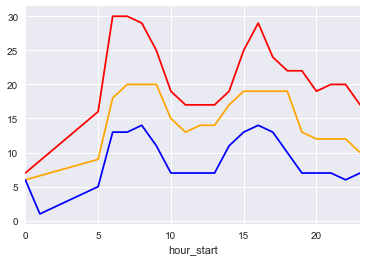

In [114]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

red_line.groupby("hour_start").trip_id.nunique().plot(color="red")
orange_line.groupby("hour_start").trip_id.nunique().plot(color="orange")
blue_line.groupby("hour_start").trip_id.nunique().plot(color="blue")

Now let's visualize the trip delays.

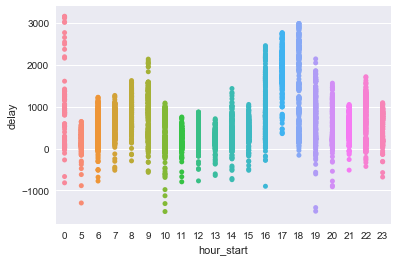

In [115]:
sns.stripplot(x="hour_start", y="delay", data=red_line)

Note that we're collapsing all the stops a trip makes into a line, so we can't distinguish between a train that leaves the first station late from a train that starts on time and gets progressively later the further it gets from its origin.

We can address this in a few ways.

We could take the mean delay of each trip:

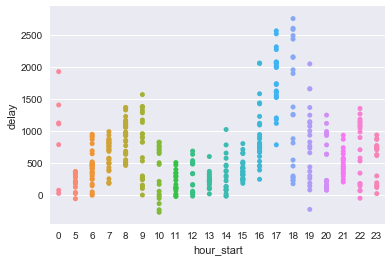

In [116]:
red_line_trips = red_line.groupby("trip_id")
red_line_trip_delays = pd.DataFrame({
    "delay": red_line_trips.delay.mean(), 
    "hour_start": red_line_trips.hour_start.first()})
sns.stripplot(x="hour_start", y="delay", data=red_line_trip_delays)

This gives an overall impression of how early or late entire trips are, but we can do better. We can use a heatmap to show the average lateness at each stop for each hour:

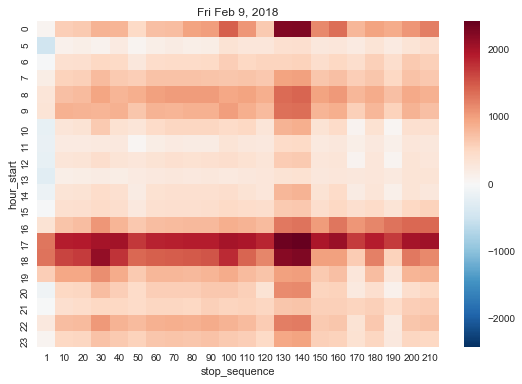

In [118]:
def reshape(stops):
    return stops.groupby("stop_sequence").delay.mean()

f, ax = plt.subplots(figsize=(9, 6))
plt.title(day.strftime("%a %b %-d, %Y"))
sns.heatmap(red_line.groupby("hour_start").apply(reshape), 
            ax=ax)
# orange_line.groupby("hour_start").apply(reshape)

We could also take a closer look at the trips for a particular hour. In particular, let's look at delays plotted against `stop_sequence`.

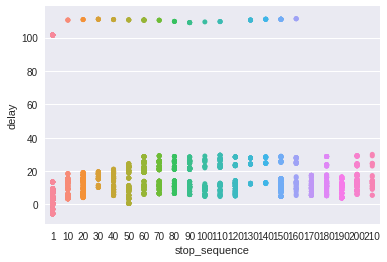

In [61]:
red_line_7 = red_line.query("hour_start == 7")
sns.stripplot(x="stop_sequence", 
              y="delay", 
              data=red_line_7)

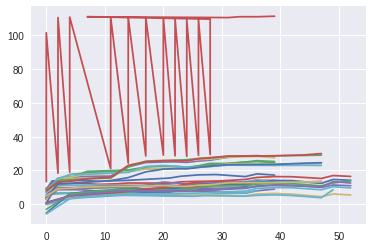

In [62]:
plt.figure(1)

for trip_id, stops in red_line_7.groupby("trip_id"):
    plt.plot(stops.schedule_offset/60, stops.delay, label=trip_id)

plt.show()

In [63]:
red_line_7_stops = red_line_7.groupby("stop_sequence").delay.describe()
red_line_7_stops.head()

,count,mean,std,min,25%,50%,75%,max
stop_sequence,,,,,,,,
1,528.0,10.024811,24.003073,-5.7,2.80,4.15,8.0,101.5
10,122.0,12.698361,16.250482,3.3,5.35,12.00,14.6,110.5
20,136.0,13.423529,15.373519,4.1,6.50,11.80,15.4,110.8
30,47.0,25.940426,29.805753,10.2,15.20,16.50,18.6,111.0
40,127.0,15.122047,17.949585,5.3,7.90,10.60,16.7,110.8


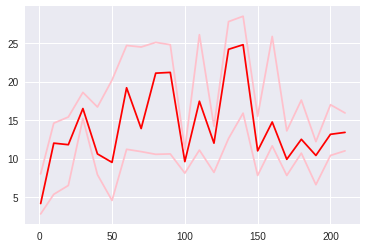

In [64]:
plt.figure(1)
plt.plot(red_line_7_stops["50%"], color="red")
plt.plot(red_line_7_stops["25%"], color="pink")
plt.plot(red_line_7_stops["75%"], color="pink")
plt.show()

This shows us the bounds of the middle 50 of the delays on red line trains starting between 7 and 8 am.

We can show the 

IndexError: ignored

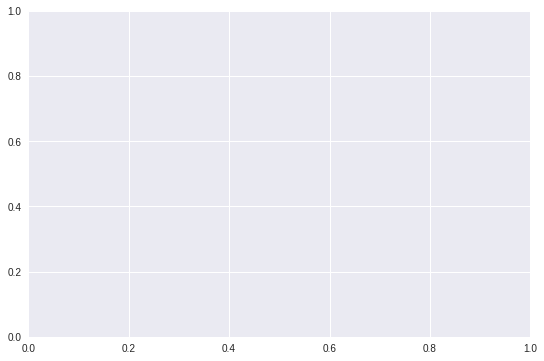

In [65]:
def reshape(stops):
    return stops.groupby("stop_sequence").delay.mean()

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(red_line.groupby("hour_start").apply(reshape), 
            ax=ax)

In [69]:
red_line_7.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,arrival_time,route_id,direction_id,scheduled_arrival_time,delay,hour_start,schedule_offset
127636,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0
127637,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0
127638,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0
127639,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0
127640,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0


How about some readable stop names?

In [66]:
stop_info = get_zip_item(static_feed, "stops")
stop_info.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding
0,Wareham Village,NaN,Wareham Village,NaN,41.758333,-70.714722,NaN,NaN,0,NaN,1
1,Buzzards Bay,NaN,Buzzards Bay,NaN,41.744805,-70.616226,NaN,NaN,0,NaN,1
2,Hyannis,NaN,Hyannis,NaN,41.660225,-70.276583,NaN,NaN,0,NaN,1
3,Logan-E,NaN,Logan Airport Terminal E,NaN,42.370022,-71.020754,NaN,NaN,0,NaN,1
4,Logan-Subway,NaN,Airport Subway Station,NaN,42.374699,-71.029831,NaN,NaN,0,NaN,1


In [77]:
red_line_stops_named = pd.merge(red_line_7, stop_info[["stop_id", "stop_name"]], on=["stop_id"])
red_line_stops_named.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,arrival_time,route_id,direction_id,scheduled_arrival_time,delay,hour_start,schedule_offset,stop_name
0,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0,Ashmont - Inbound
1,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0,Ashmont - Inbound
2,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0,Ashmont - Inbound
3,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0,Ashmont - Inbound
4,35448339-L,2018-03-05,70094,50,54541867,STOPPED_AT,2018-03-05 07:05:38-05:00,42.28458,-71.063766,07:05:00,Red,1,2018-03-05 07:05:00-05:00,0.6,7,0.0,Ashmont - Inbound


AttributeError: ignored

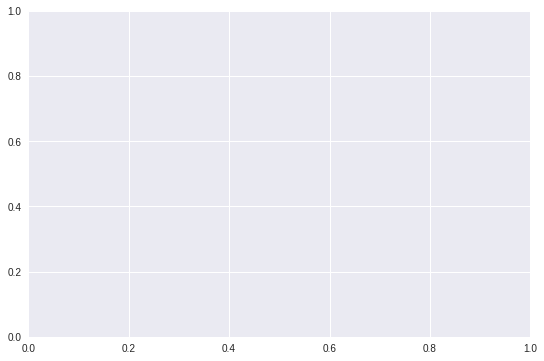

In [79]:
def reshape(stops):
    return stops.groupby("stop_sequence").delay.mean()

f, ax = plt.subplots(figsize=(9, 6))
reshaped_red_line_stops_named = red_line_stops_named.groupby("hour_start").apply(reshape)
# sns.heatmap(reshaped_red_line_stops_named, xticklabels=red_line
#             ax=ax
reshaped_red_line_stops_named.stop_name

In [73]:
routes = get_zip_item(static_feed, "routes")
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,route_sort_order
0,CapeFlyer,3,NaN,CapeFLYER,NaN,2,http://capeflyer.com/,006595,FFFFFF,100
1,Logan-22,2,Shuttle,Massport Subway Shuttle (22),Airport Shuttle,3,NaN,NaN,NaN,2000022
2,Logan-33,2,Shuttle,Massport Subway Shuttle (33),Airport Shuttle,3,NaN,NaN,NaN,2000033
3,Logan-55,2,Shuttle,Massport Subway Shuttle (55),Airport Shuttle,3,NaN,NaN,NaN,2000055
4,Logan-66,2,Shuttle,Massport Subway / Ferry Terminal Shuttle (66),Airport Shuttle,3,NaN,NaN,NaN,2000066


In [0]:
routes[routes.agency_id == 2]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,route_sort_order
1,Logan-22,2,Shuttle,Massport Subway Shuttle (22),Airport Shuttle,3,NaN,NaN,NaN,2000022
2,Logan-33,2,Shuttle,Massport Subway Shuttle (33),Airport Shuttle,3,NaN,NaN,NaN,2000033
3,Logan-55,2,Shuttle,Massport Subway Shuttle (55),Airport Shuttle,3,NaN,NaN,NaN,2000055
4,Logan-66,2,Shuttle,Massport Subway / Ferry Terminal Shuttle (66),Airport Shuttle,3,NaN,NaN,NaN,2000066


In [0]:
# 
# recent_updates.head()
# trips
# recent_updates.trip_id = recent_updates.trip_id.str.strip()
# pd.merge(recent_updates, trips, on="trip_id")
recent_updates = get_updates(datetime.now() - timedelta(days=1))
recent_updates = pd.merge(recent_updates, trips, on="trip_id")

In [0]:
recent_updates.route_id.nunique()

194

In [0]:
grouped_routes = recent_updates.groupby("route_id")
distinct_trips = grouped_routes.trip_id.nunique()
distinct_updates = grouped_routes.count().trip_id

In [0]:
route_stats = pd.concat({"trips": distinct_trips, "updates": distinct_updates}, axis=1)
route_stats["updates per trip"] = route_stats["updates"]/route_stats["trips"]
route_stats.sort_values("updates", ascending=False)

NameError: name 'pd' is not defined

In [0]:
orange_line = stops_with_schedule.query("route_id == 'Orange'").groupby("trip_id").apply(add_hour_start)
blue_line = stops_with_schedule.query("route_id == 'Blue'").groupby("trip_id").apply(add_hour_start)

# Vehicle Clusters

In [48]:
named_stops.sort_values("local_timestamp", inplace=True)
red_line = named_stops.query("route_id == 'Red'")
orange_line = named_stops.query("route_id == 'Orange'")
blue_line = named_stops.query("route_id == 'Blue'")

In [49]:
# Group by stop_id and direction_id?

rl_grouped = red_line.groupby(["stop_id", "direction_id"])

def add_headway(df):
  df["headway"] = (df.local_timestamp.diff(1)).dt.total_seconds()
  return df

rl_with_headway = rl_grouped.apply(add_headway)
rl_with_headway.tail()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,local_timestamp,route_id,direction_id,stop_name,headway
271905,36491786-L,2018-05-31,70093,170,R-5455F2F5,2018-05-31 21:59:03-04:00,Red,0,Ashmont - Outbound,556.0
262505,36491860-L,2018-05-31,70105,220,R-5455E8B5,2018-05-31 21:59:10-04:00,Red,0,Braintree,764.0
244404,36491795-L,2018-05-31,70073,60,R-5455F415,2018-05-31 21:59:14-04:00,Red,0,Charles/MGH - Inbound,255.0
281942,36491777-L,2018-05-31,70090,70,R-5455F127,2018-05-31 21:59:20-04:00,Red,1,Fields Corner - Inbound,1028.0
264076,36491843-L,2018-05-31,70068,190,R-5455F449,2018-05-31 21:59:51-04:00,Red,1,Harvard - Outbound,505.0


In [56]:
one_stop = rl_with_headway.query("stop_sequence == 100 and direction_id == '1'")
one_stop.head(10)

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,local_timestamp,route_id,direction_id,stop_name,headway
249018,36491711-L,2018-05-31,70096,100,R-5455DD44,2018-05-31 05:39:02-04:00,Red,1,JFK/UMASS Braintree - Inbound,NaN
249019,36491715-L,2018-05-31,70096,100,R-5455E5E4,2018-05-31 05:47:02-04:00,Red,1,JFK/UMASS Braintree - Inbound,480.0
249020,36491713-L,2018-05-31,70096,100,R-5455E1C8,2018-05-31 05:55:26-04:00,Red,1,JFK/UMASS Braintree - Inbound,504.0
249021,36491717-L,2018-05-31,70096,100,R-5455F126,2018-05-31 06:16:48-04:00,Red,1,JFK/UMASS Braintree - Inbound,1282.0
249022,36491724-L,2018-05-31,70096,100,R-5455EB92,2018-05-31 06:23:38-04:00,Red,1,JFK/UMASS Braintree - Inbound,410.0
249023,36491880-L,2018-05-31,70096,100,R-5455F12E,2018-05-31 06:30:55-04:00,Red,1,JFK/UMASS Braintree - Inbound,437.0
249024,36491738-L,2018-05-31,70096,100,R-5455F135,2018-05-31 06:39:26-04:00,Red,1,JFK/UMASS Braintree - Inbound,511.0
249025,36491720-L,2018-05-31,70096,100,R-5455F103,2018-05-31 06:47:10-04:00,Red,1,JFK/UMASS Braintree - Inbound,464.0
249026,36491722-L,2018-05-31,70096,100,R-5455E8B5,2018-05-31 06:50:42-04:00,Red,1,JFK/UMASS Braintree - Inbound,212.0
249027,36754130-L,2018-05-31,70096,100,R-5455EB15,2018-05-31 06:57:30-04:00,Red,1,JFK/UMASS Braintree - Inbound,408.0


Let's see if we can find clusters at this stop.

We'll define a cluster as one or more vehicles that have less than a 300 second (five minute) interval between arrivals at a given stop. We'll give each cluster a unique number, starting at 0.

We'll take advantage of the fact that `False` = 0 and `True` = 1, and we'll use the `cumsum()` Series method to get the cumulative sum of a boolean column. The intuition is that each time we exceed the cluster threshold for time between vehicles, we increment `cluster`.

In [57]:
one_stop["cluster"] = (one_stop.headway >= 300).cumsum()
one_stop

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,local_timestamp,route_id,direction_id,stop_name,headway,cluster
249018,36491711-L,2018-05-31,70096,100,R-5455DD44,2018-05-31 05:39:02-04:00,Red,1,JFK/UMASS Braintree - Inbound,NaN,0
249019,36491715-L,2018-05-31,70096,100,R-5455E5E4,2018-05-31 05:47:02-04:00,Red,1,JFK/UMASS Braintree - Inbound,480.0,1
249020,36491713-L,2018-05-31,70096,100,R-5455E1C8,2018-05-31 05:55:26-04:00,Red,1,JFK/UMASS Braintree - Inbound,504.0,2
249021,36491717-L,2018-05-31,70096,100,R-5455F126,2018-05-31 06:16:48-04:00,Red,1,JFK/UMASS Braintree - Inbound,1282.0,3
249022,36491724-L,2018-05-31,70096,100,R-5455EB92,2018-05-31 06:23:38-04:00,Red,1,JFK/UMASS Braintree - Inbound,410.0,4
249023,36491880-L,2018-05-31,70096,100,R-5455F12E,2018-05-31 06:30:55-04:00,Red,1,JFK/UMASS Braintree - Inbound,437.0,5
249024,36491738-L,2018-05-31,70096,100,R-5455F135,2018-05-31 06:39:26-04:00,Red,1,JFK/UMASS Braintree - Inbound,511.0,6
249025,36491720-L,2018-05-31,70096,100,R-5455F103,2018-05-31 06:47:10-04:00,Red,1,JFK/UMASS Braintree - Inbound,464.0,7
249026,36491722-L,2018-05-31,70096,100,R-5455E8B5,2018-05-31 06:50:42-04:00,Red,1,JFK/UMASS Braintree - Inbound,212.0,7
249027,36754130-L,2018-05-31,70096,100,R-5455EB15,2018-05-31 06:57:30-04:00,Red,1,JFK/UMASS Braintree - Inbound,408.0,8


How many clusters do we have?

In [58]:
print("Total:", len(one_stop))
print("Clusters:", one_stop.cluster.nunique())

Total: 82
Clusters: 80


In other words, there are only two clusters of two or more vehicles. Pretty boring.

We can quickly experiment with some other threshold headways:

In [67]:
print("300 second headway:", sum(one_stop.headway < 300)) # Note that we invert the condition
print("360 second headway:", sum(one_stop.headway < 360))
print("420 second headway:", sum(one_stop.headway < 420))

300 second headway: 2
360 second headway: 6
420 second headway: 10


We can see how many clusters we get at each stop on the red line for a given threshold;

In [75]:
one_direction = rl_with_headway.query("direction_id == '1'")
# 3 minute headway:
one_direction.groupby("stop_sequence").apply(lambda grp: pd.Series({"stop_name": grp.stop_name.iloc[0], "clusters": sum(grp.headway < 180)}))

,clusters,stop_name
stop_sequence,,
1,12,Braintree
10,0,Quincy Adams - Inbound
20,0,Quincy Center - Inbound
40,0,North Quincy - Inbound
50,11,Ashmont - Inbound
60,0,Shawmut - Inbound
70,0,Fields Corner - Inbound
80,0,Savin Hill - Inbound
90,0,JFK/UMASS Ashmont - Inbound


In [12]:
n_df["odd"] = (n_df.a % 2)
n_df

,a,b,c,d,e,odd
0,51,40,99,97,94,1
1,10,27,29,76,34,0
2,62,28,30,58,40,0
3,23,70,28,12,97,1
4,19,50,22,87,84,1


In [16]:
n_df.groupby("odd").size()
# n_df.groupby("odd", as_index=False).size()

odd
0    2
1    3
dtype: int64

If we want to get a little fancy, we can also look up the maximum timestamp for each `trip_id` and `stop_sequence`. Here, we use a `groupby` operation to create groups where the trip and stop sequence are the same and find the index of the maximum timestamp within each group.

The call to `idxmax()`, in conjunction with the groupby, creates a `MultiIndex` that we can then use as a label-based index into the original dataframe.

The effect is to select the last update for a stop on a particular trip on the chosen day. Occasionally, vehicles may not send an update with status STOPPED_AT for a particular stop. It's worth considering this as a way to capture more stop times.

In [28]:
stops = df.loc[df.groupby(["trip_id","stop_sequence"])["local_timestamp"].idxmax()]
stops.head()

,trip_id,trip_start,stop_id,stop_sequence,vehicle_id,status,timestamp,lat,lon,local_timestamp
127758,36240875,2018-05-25,70038,1,B-5455D328,STOPPED_AT,2018-05-25 09:36:33,42.361148834228516,-71.06208038330078,2018-05-25 05:36:33-04:00
128741,36240875,2018-05-25,70040,10,B-5455D328,STOPPED_AT,2018-05-25 09:37:23,42.35948944091797,-71.0596923828125,2018-05-25 05:37:23-04:00
130396,36240875,2018-05-25,70042,20,B-5455D328,STOPPED_AT,2018-05-25 09:38:37,42.35887908935547,-71.05738830566406,2018-05-25 05:38:37-04:00
132101,36240875,2018-05-25,70044,30,B-5455D328,STOPPED_AT,2018-05-25 09:39:57,42.35955810546875,-71.05162048339844,2018-05-25 05:39:57-04:00
136020,36240875,2018-05-25,70046,40,B-5455D328,STOPPED_AT,2018-05-25 09:42:36,42.369239807128906,-71.0394287109375,2018-05-25 05:42:36-04:00


Remove the commuter rail and ferries:

What is the relationship of tweet volume/minute and delays?

In [41]:
!pip install TwitterAPI

  Running setup.py bdist_wheel for TwitterAPI ... - \ done
  Stored in directory: /content/.cache/pip/wheels/b9/d4/30/5ede07ac4142224dbbb28b9a2eed35554e21c6bd6aa5e76755
Successfully built TwitterAPI


In [0]:
from TwitterAPI import TwitterAPI, TwitterRestPager
consumer_key = "iJcZc53yULImIO7P0GteQzkdy"
consumer_secret = "2BHrct9oTKpIQz6cVqoB5xqdA5KlbJ7hXLd5bEt8oKsU9f2tIu"
access_token = "928752949760872448-5P8U6z5SitlKKD1DJFy7t51a5pR8gKn"
access_token_secret = "zWf3afpJ1royeAy7jysqAUuEhHjyMqnHCoFh7nmmjbhZA"
api = TwitterAPI(consumer_key, consumer_secret, access_token, access_token_secret)

In [0]:
r = api.request("search/tweets", {"q": "@MBTA"})

In [44]:
# [status["text"] for status in r.json()["statuses"]]
r.json()["statuses"][0].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'metadata', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang'])

In [45]:
r.json()["statuses"][0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Mar 07 01:44:24 +0000 2018',
 'entities': {'hashtags': [{'indices': [10, 15], 'text': 'MBTA'},
   {'indices': [16, 24], 'text': 'RedLine'}],
  'symbols': [],
  'urls': [],
  'user_mentions': [{'id': 150334831,
    'id_str': '150334831',
    'indices': [3, 8],
    'name': 'MBTA',
    'screen_name': 'MBTA'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 971199857342939137,
 'id_str': '971199857342939137',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'place': None,
 'retweet_count': 1,
 'retweeted': False,
 'retweeted_status': {'contributors': None,
  'coordinates': None,
  'created_at': 'Wed Mar 07 01:36:21 +0000 2018',
  'entities': {'hashtags': [{'indices': [0, 5], 'text': 'M

In [0]:
from datetime import datetime
datetime.strptime("")
r.json()["statuses"][0]["created_at"]

TypeError: strptime() takes exactly 2 arguments (1 given)

In [0]:
"%a %b %d %H:%M:%S %z %Y"

api.request("statuses/filter", {"track": "@MBTA"})
for item in r:
    print(item)

{'created_at': 'Thu Nov 09 22:42:25 +0000 2017', 'id': 928754676799033346, 'id_str': '928754676799033346', 'text': 'Adding buses to the traffic does nothing positive! Build a train! Silver line sucks @MBTA https://t.co/4MY8CPiq5D', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'MBTA', 'name': 'MBTA', 'id': 150334831, 'id_str': '150334831', 'indices': [84, 89]}], 'urls': [], 'media': [{'id': 928754670973177856, 'id_str': '928754670973177856', 'indices': [90, 113], 'media_url': 'http://pbs.twimg.com/media/DOOZc9bXUAARxy3.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DOOZc9bXUAARxy3.jpg', 'url': 'https://t.co/4MY8CPiq5D', 'display_url': 'pic.twitter.com/4MY8CPiq5D', 'expanded_url': 'https://twitter.com/MattSheehan1985/status/928754676799033346/photo/1', 'type': 'photo', 'sizes': {'large': {'w': 575, 'h': 1024, 'resize': 'fit'}, 'medium': {'w': 575, 'h': 1024, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'sma

In [0]:
datetime.strptime("Thu Nov 09 22:42:25 -0000 2017", "%a %b %d %H:%M:%S %z %Y"
                 )

datetime.datetime(2017, 11, 9, 22, 42, 25, tzinfo=datetime.timezone.utc)

In [0]:
import pytz
help(pytz)

Help on package pytz:

NAME
    pytz

DESCRIPTION
    datetime.tzinfo timezone definitions generated from the
    Olson timezone database:
    
        ftp://elsie.nci.nih.gov/pub/tz*.tar.gz
    
    See the datetime section of the Python Library Reference for information
    on how to use these modules.

PACKAGE CONTENTS
    exceptions
    lazy
    reference
    tzfile
    tzinfo

CLASSES
    builtins.Exception(builtins.BaseException)
        pytz.exceptions.InvalidTimeError
            pytz.exceptions.AmbiguousTimeError
            pytz.exceptions.NonExistentTimeError
    builtins.KeyError(builtins.LookupError)
        pytz.exceptions.UnknownTimeZoneError
    
    class AmbiguousTimeError(InvalidTimeError)
     |  Exception raised when attempting to create an ambiguous wallclock time.
     |  
     |  At the end of a DST transition period, a particular wallclock time will
     |  occur twice (once before the clocks are set back, once after). Both
     |  possibilities may be correct,